In [ ]:
#| hide
!pip install -Uqq nixtla

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Quantile forecasts

In forecasting, we are often interested in a distribution of predictions rather than only a point prediction, because we want to have a notion of the uncertainty around the forecast.\
\
To this end, we can create _quantile forecasts_.\
\
Quantile forecasts have an intuitive interpretation, as they present a specific percentile of the forecast distribution. This allows us to make statements such as 'we expect 90% of our observations of air passengers to be above 100'. This approach is helpful for planning under uncertainty, providing a spectrum of possible future values and helping users make more informed decisions by considering the full range of potential outcomes.\
\
With TimeGPT, we can create a distribution of forecasts, and extract the quantile forecasts for a specified percentile. For instance, the 25th and 75th quantiles give insights into the lower and upper quartiles of expected outcomes, respectively, while the 50th quantile, or median, offers a central estimate.\
\
TimeGPT uses [conformal prediction](https://en.wikipedia.org/wiki/Conformal_prediction) to produce the quantiles.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()    
    colab_badge('docs/tutorials/10_uncertainty_quantification_with_quantile_forecasts')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/10_uncertainty_quantification_with_quantile_forecasts.ipynb)

## 1. Import packages
First, we import the required packages and initialize the Nixtla client

In [ ]:
import pandas as pd
from nixtla import NixtlaClient

from IPython.display import display

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
>
> To use an Azure AI endpoint, set the `base_url` argument:
>
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Load data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
df.head()

,timestamp,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


## 3. Forecast with quantiles
When using TimeGPT for time series forecasting, you can set the quantiles you want to predict. Here's how you could do it:

In [ ]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
timegpt_quantile_fcst_df = nixtla_client.forecast(
    df=df, h=12, 
    quantiles=quantiles, 
    time_col='timestamp', target_col='value',
)
timegpt_quantile_fcst_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,timestamp,TimeGPT,TimeGPT-q-10,TimeGPT-q-20,TimeGPT-q-30,TimeGPT-q-40,TimeGPT-q-50,TimeGPT-q-60,TimeGPT-q-70,TimeGPT-q-80,TimeGPT-q-90
0,1961-01-01,437.837952,431.987091,435.043799,435.384363,436.402155,437.837952,439.273749,440.291541,440.632104,443.688812
1,1961-02-01,426.062744,412.704956,414.832837,416.042432,421.719196,426.062744,430.406293,436.083057,437.292651,439.420532
2,1961-03-01,463.116577,437.412564,444.234985,446.420233,450.705762,463.116577,475.527393,479.812921,481.998169,488.820590
3,1961-04-01,478.244507,448.726837,455.428375,465.570038,469.879114,478.244507,486.609900,490.918976,501.060638,507.762177
4,1961-05-01,505.646484,478.409872,493.154315,497.990848,499.138708,505.646484,512.154260,513.302121,518.138654,532.883096


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

TimeGPT will return forecasts in the format `TimeGPT-q-{int(100 * q)}` for each quantile `q`.

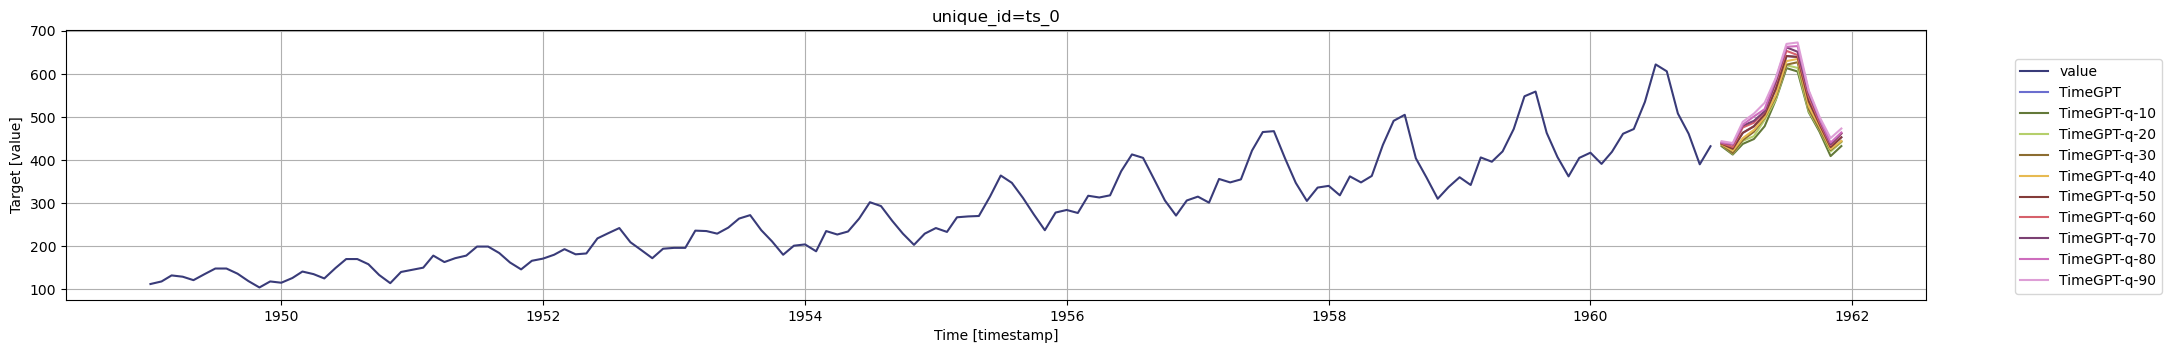

In [ ]:
nixtla_client.plot(
    df, timegpt_quantile_fcst_df, 
    time_col='timestamp', target_col='value',
)

It's essential to note that the choice of the quantile (or quantiles) depends on your specific use case. For high-stakes predictions, you might lean towards more conservative quantiles, such as the 10th or 20th percentile, to ensure you're prepared for worse-case scenarios. On the other hand, if you're in a situation where the cost of over-preparation is high, you might choose a quantile closer to the median, like the 50th percentile, to balance being cautious and efficient.

For instance, if you are managing inventory for a retail business during a big sale event, opting for a lower quantile might help you avoid running out of stock, even if it means you might overstock a bit. But if you are scheduling staff for a restaurant, you might go with a quantile closer to the middle to ensure you have enough staff on hand without significantly overstaffing.

Ultimately, the choice comes down to understanding the balance between risk and cost in your specific context, and using quantile forecasts from TimeGPT allows you to tailor your strategy to fit that balance perfectly.

#### Historical Forecast

You can also compute quantile forecasts for historical forecasts adding the `add_history=True` parameter as follows:

In [ ]:
timegpt_quantile_fcst_df = nixtla_client.forecast(
    df=df, h=12, 
    quantiles=quantiles, 
    time_col='timestamp', target_col='value',
    add_history=True,
)
timegpt_quantile_fcst_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...


,timestamp,TimeGPT,TimeGPT-q-10,TimeGPT-q-20,TimeGPT-q-30,TimeGPT-q-40,TimeGPT-q-50,TimeGPT-q-60,TimeGPT-q-70,TimeGPT-q-80,TimeGPT-q-90
0,1951-01-01,135.483673,111.937768,120.020593,125.848879,130.828935,135.483673,140.138411,145.118467,150.946753,159.029579
1,1951-02-01,144.442398,120.896493,128.979318,134.807604,139.787660,144.442398,149.097136,154.077192,159.905478,167.988304
2,1951-03-01,157.191910,133.646004,141.728830,147.557116,152.537172,157.191910,161.846648,166.826703,172.654990,180.737815
3,1951-04-01,148.769363,125.223458,133.306284,139.134570,144.114625,148.769363,153.424102,158.404157,164.232443,172.315269
4,1951-05-01,140.472946,116.927041,125.009866,130.838152,135.818208,140.472946,145.127684,150.107740,155.936026,164.018852


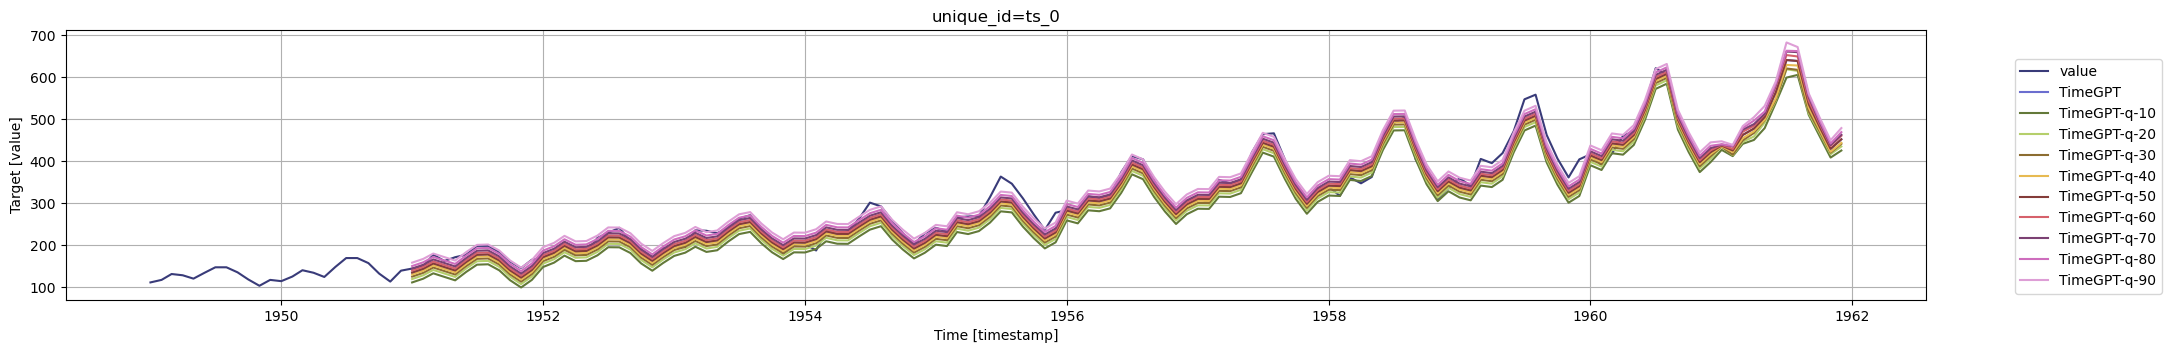

In [ ]:
nixtla_client.plot(
    df, timegpt_quantile_fcst_df, 
    time_col='timestamp', target_col='value',
)

#### Cross Validation

The `quantiles` argument can also be included in the `cross_validation` method, allowing comparing the performance of TimeGPT across different windows and different quantiles.

In [ ]:
timegpt_cv_quantile_fcst_df = nixtla_client.cross_validation(
    df=df, 
    h=12, 
    n_windows=5,
    quantiles=quantiles, 
    time_col='timestamp', 
    target_col='value',
)
timegpt_quantile_fcst_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:V

,timestamp,TimeGPT,TimeGPT-q-10,TimeGPT-q-20,TimeGPT-q-30,TimeGPT-q-40,TimeGPT-q-50,TimeGPT-q-60,TimeGPT-q-70,TimeGPT-q-80,TimeGPT-q-90
0,1951-01-01,135.483673,111.937768,120.020593,125.848879,130.828935,135.483673,140.138411,145.118467,150.946753,159.029579
1,1951-02-01,144.442398,120.896493,128.979318,134.807604,139.787660,144.442398,149.097136,154.077192,159.905478,167.988304
2,1951-03-01,157.191910,133.646004,141.728830,147.557116,152.537172,157.191910,161.846648,166.826703,172.654990,180.737815
3,1951-04-01,148.769363,125.223458,133.306284,139.134570,144.114625,148.769363,153.424102,158.404157,164.232443,172.315269
4,1951-05-01,140.472946,116.927041,125.009866,130.838152,135.818208,140.472946,145.127684,150.107740,155.936026,164.018852


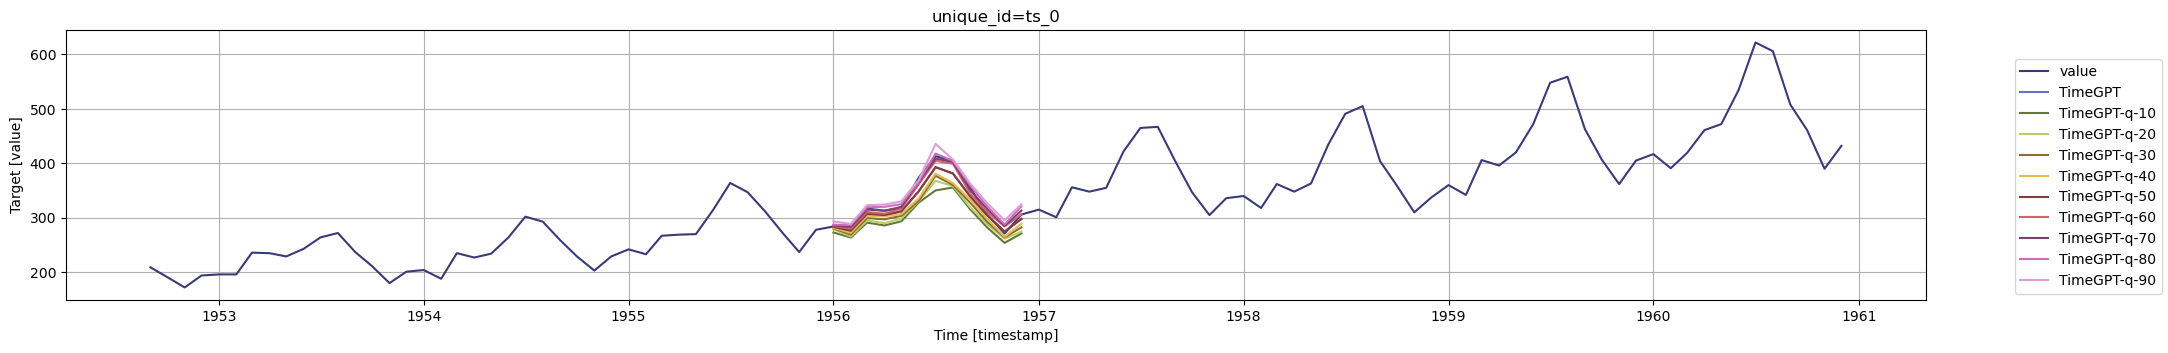

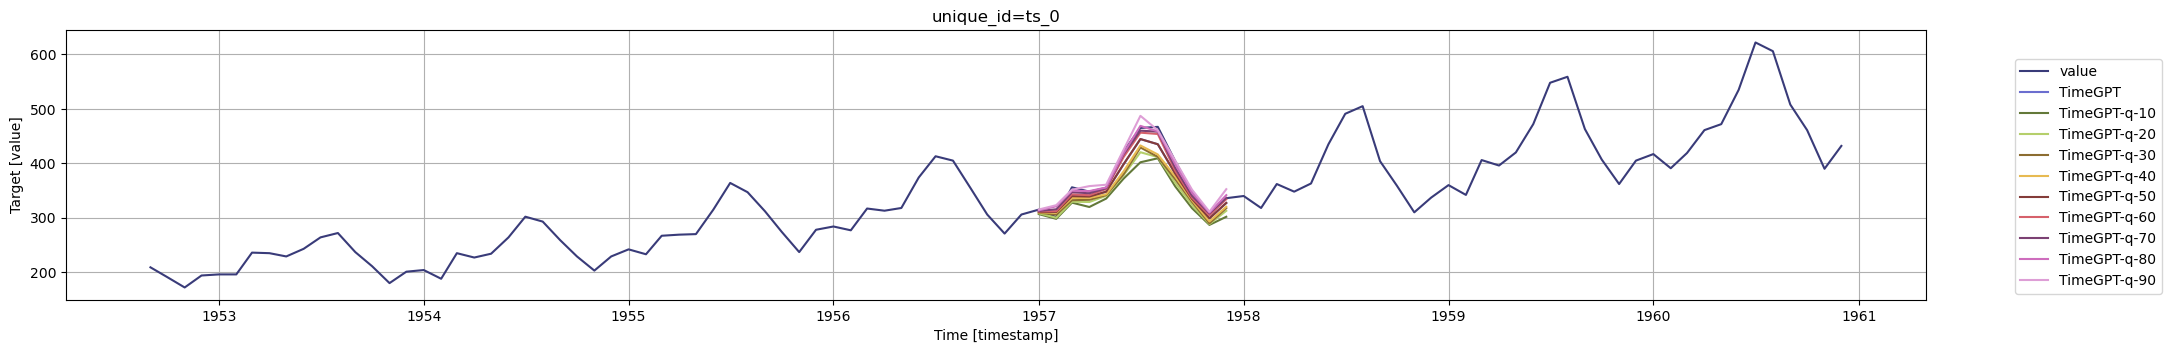

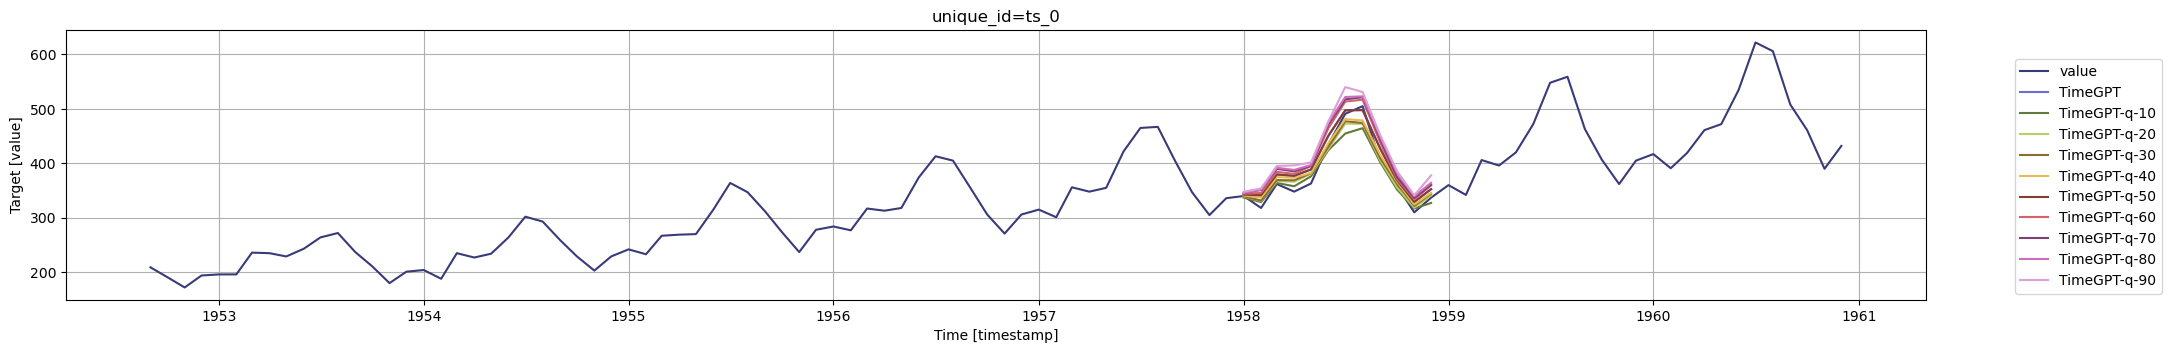

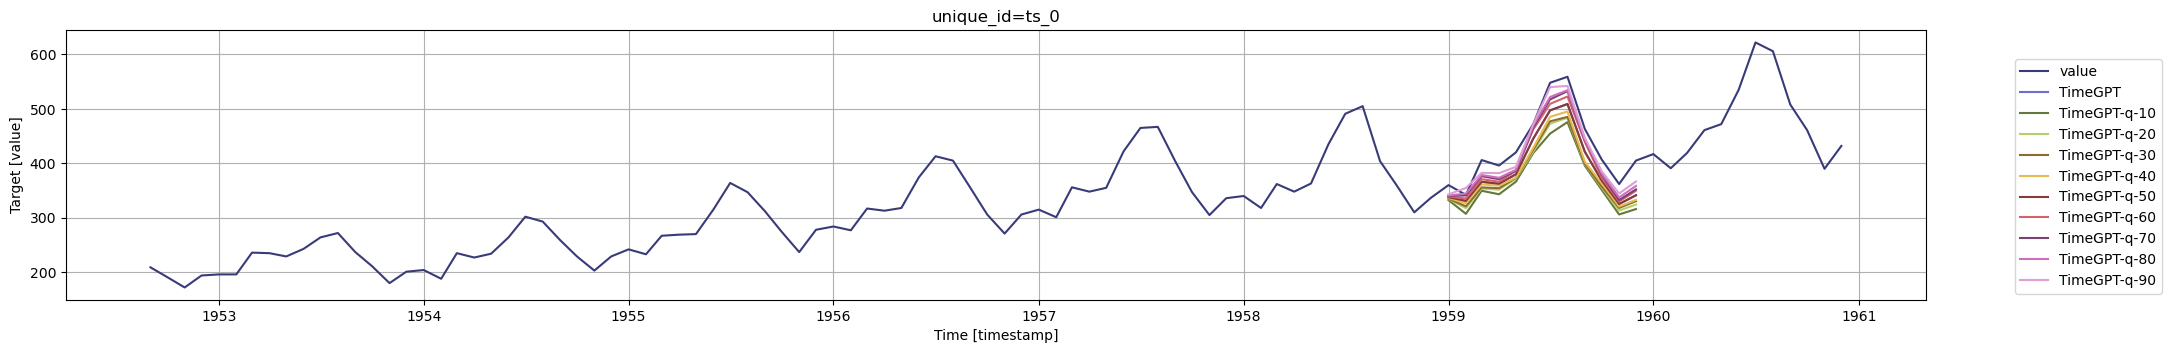

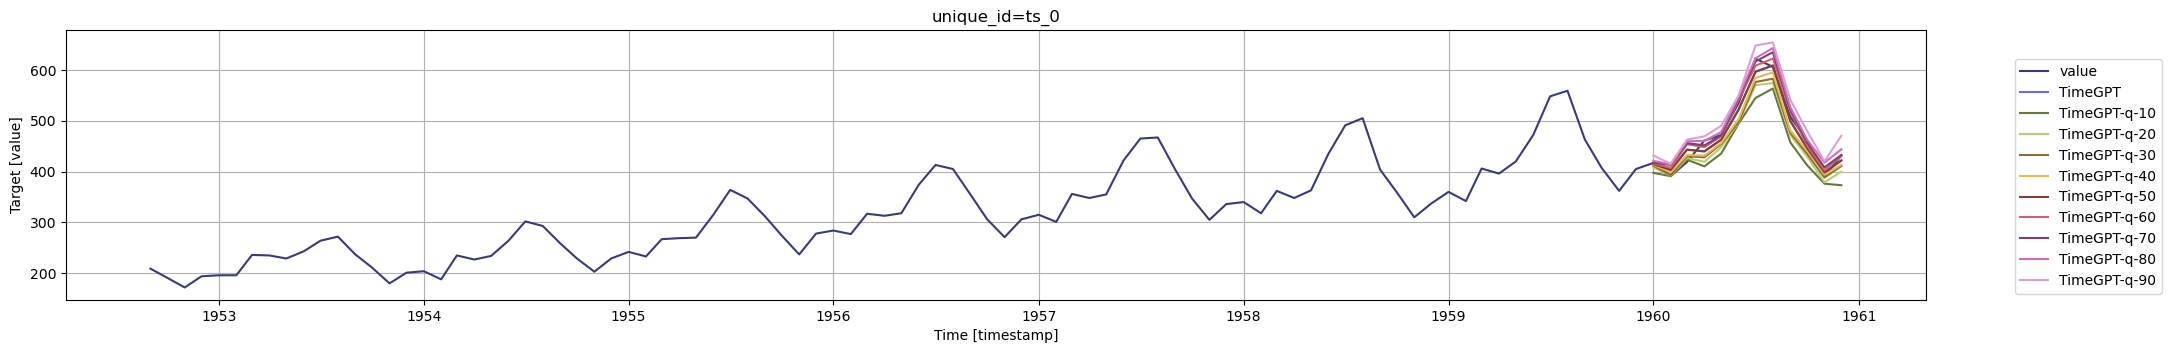

In [ ]:
cutoffs = timegpt_cv_quantile_fcst_df['cutoff'].unique()
for cutoff in cutoffs:
    fig = nixtla_client.plot(
        df.tail(100), 
        timegpt_cv_quantile_fcst_df.query('cutoff == @cutoff').drop(columns=['cutoff', 'value']),
        time_col='timestamp', 
        target_col='value'
    )
    display(fig)